# RL coursework, part IV (30 pts in total)

---

**SN:** 15056601

---

**Due date:** *22nd March, 2022,*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [6]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [7]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with full importance-sampling corrections, so that
    the return G_t is corrected with the full importance-sampling correction of
    the rest of the trajectory.
    """
    
    # Compute the value return for each observation
    value = np.array([])
    for obs in observations:
        value = np.append(value, v_fn(obs))
    
    # Define the average return 
    G = np.zeros((len(rewards),))
    
    # Define the trace
    t = np.zeros((len(rewards),))
   
    # Iterating backwards for the full importance-sampling corrections
    for step in reversed(range(len(rewards))):
        # If we are the last step
        if step == len(rewards)-1:
            # Update the return
            G[step] = rewards[step] + discounts[step]*value[step+1]
            # Update the trace
            t[step] = pi[step]/mu[step]
        else:
            G[step] = rewards[step] + discounts[step]*((1-trace_parameter)*value[step+1] + trace_parameter*G[step+1])    
            # Update the trace
            t[step] = (pi[step]/mu[step])*t[step+1]
    G *= t
    off_policy_ret = (1-trace_parameter)*value[:-1] + trace_parameter*G
    return off_policy_ret


def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with per-decision importance-sampling corrections.
    """
    # Compute the value return for each observation
    value = np.array([])
    for obs in observations:
        value = np.append(value, v_fn(obs))
    
    # Define the average return 
    G = np.zeros((len(rewards),))
    
    for step in reversed(range(len(rewards))):
        if step == len(rewards) - 1:
            G[step] = pi[step] / mu[step] * (rewards[step] + discounts[step]*value[step + 1])
        else:
            G[step] =  pi[step] / mu[step] * (rewards[step] + discounts[step]*((1 - trace_parameter)*value[step + 1] + trace_parameter*G[step + 1]))
    
    off_policy_ret = (1 - trace_parameter)*value[:-1] + trace_parameter*G
    return off_policy_ret

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with 
    1. per-decision importance-sampling corrections, and
    2. control variates
    """
    # Compute the value return for each observation
    value = np.array([])
    for obs in observations:
        value = np.append(value, v_fn(obs))
    
    # Define the average return 
    G = np.zeros((len(rewards),))
    
    for step in reversed(range(len(rewards))):
        if step == len(rewards) - 1:
            G[step] = (pi[step] / mu[step] ) * (rewards[step] + discounts[step]*value[step + 1]) + (1 - (pi[step] / mu[step] )) * value[step]
         
        else: 
            G[step] =  (pi[step] / mu[step] ) * (rewards[step] + discounts[step]*((1 - trace_parameter)*value[step + 1] + trace_parameter*G[step + 1])) + (1 - (pi[step] / mu[step] )) * value[step]
    off_policy_ret = (1 - trace_parameter)*value[:-1]   + trace_parameter*G
    return off_policy_ret

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with 
    1. per-decision importance-sampling corrections, and
    2. control variates, and
    3. adaptive bootstrapping.

    Implement the adaptive bootstrapping with an *additional* trace parameter
    lambda, such that lambda_t = lambda * min(1, 1/rho_t).
    """
    # Compute the value return for each observation
    value = np.array([])
    for obs in observations:
        value = np.append(value, v_fn(obs))
    
    # Define the average return 
    G = np.zeros((len(rewards),))
    
    lambs = np.zeros((len(rewards),))
    for step in reversed(range(len(rewards))):
        lambda_t = trace_parameter * min(1, 1/(pi[step] / mu[step] ))  
        lambs[step] = lambda_t
        if step == len(rewards) - 1:
            G[step] = (pi[step] / mu[step] ) * (rewards[step] + discounts[step] * value[step+1] - value[step])
        else:
            G[step] =  (pi[step] / mu[step] ) * lambda_t * (rewards[step] + discounts[step] * value[step+1] - value[step] + discounts[step]*G[step+1])
    
    off_policy_ret = value[:-1] + lambs*G
    return off_policy_ret


In [8]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
    
  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
    
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 19.639 654.385 200.516   7.015   0.68 ]


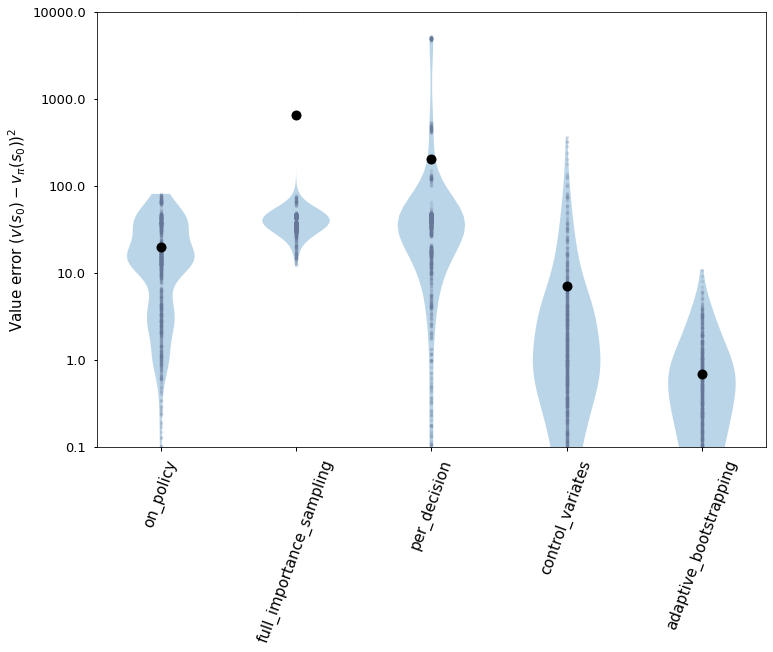

In [9]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

I will list the ranking from best to worst:
> **Adaptive boostrapping:** Adaptive bootstrapping gives us the option to control when to bootstrap. It only bootstraps when the agent selects an action that has higher likelihood under the behavioural policy than under the target policy. Therefore, by controlling the bootstrapping, adaptive bootstraping reduces the variance considerably. By avoiding bootstrapping at every instance we avoid the occurace of the deadliy triad. It is clear from the above plot that this has the lowest mean value error and also has the most compact (1,000) individual return samples hence, lowest variance. 

> **Control variates:** Control variates weights the error rather than the target. The expectation is zero, but this may vary depending on the target term. This covariance has the effect of reducing variances, we can see the mean value error reduces compared to the other approaches. 

> **On-policy:** On policy follows the target policy for exploration and does not explore optimally. The mean value error is as expected, it is not low since the agent is not given the chance to explore other potentially higher rewards actions and neither is it very high because we are effectively just following the target policy.


> **Per decision:** In per decision sampling, the expectation does not depend on the policy, so we don't need to correct it. Earlier rewards cannot depend on later actions and therefore, we do not mulitply the trace together however we multiply by $\rho$ at every step. As seen in lecture 11, this helps reduce variance but there is still very high variance. The mean value error is still high.

> **Full importance sampling:** In full importance sampling, we can have a case when an action is unlikely under the behavioural policy but likely under the target policy. This can lead to a correction coefficient that is greater than 1, cause the agent to be divergent. This can cause many outliers which is evident from the above graph. importance sampling corrections has high variance and in some cases the variance can be infinite.




### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> As I explained in the above question and as it can be seen from the graph, adaptive boosting preforms the best. However, there exists a situation where adapative boosting does not act optimally. As seen in the lecture, adaptive bootstrapping will reduce variance compared to the other approachs. Although only minimal bias is introduced, it still introduces some bias, which can be an issue if we are also using function approximation and off-policy learning in combination with the bootstrapping introduced in adaptive bootstrapping. 
This combination is called the deadly triad and it can lead to the possibility of divergence. Adaptive bootstrapping aims at boostraping just enough however, we it still might bootstrap too early which will lead to the deadly triads.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

i)

The Robbins-Monro conditions are as follows:
$$\forall s: \sum_{t=0}^{\infty}{\alpha_t(s_t,a_t)=\infty}, \forall s: \sum_{t=0}^{\infty}{(\alpha_t(s_t,a_t))^2 < \infty}$$

With reference to  Convergence of Q-learning: A Simple Proof (by Francisco S. Melo), we see from theorem 1 that Q-learning  a TD algorithm converges with probability 1 too the optimal Q-function as long as the Robbins-Monro conditions are met, for all combinations of states and actions. To establish the above result we need an auxiliary result from stochastic approximation, that I will present:

The random process ${\Delta t}$ taking values in $R^n$ and defined as
$\Delta t+1(x) = (1 − \alpha t(x))\Delta t(x) + \alpha t(x)Ft(x)$ converges to zero with probability 1 under the following assumptions: 
- $0 \leq \alpha_t \leq 1, \sum_{t=0}^{\infty}{\alpha_t(x)=\infty}and  \sum_{t=0}^{\infty}{(\alpha_t(x))^2 < \infty} $
- $||E\left[F_t|\tau_t \right]||_W \le \gamma ||\Delta_t||_W + c_t$
- $Var \left[F_t(x_t)|\tau_t \right] < C (1+\gamma||\Delta_t||_W)^2, \forall C > 0$

This auxiliary theorem is sufficient to show that the value function converges. 

With references to page 33 of Sutton & Barton book, the first Robbins-Monro condition is required to guarantee that the steps are large enough to eventually overcome any initial conditions or random fluctuations. The second condition guarantees that eventually the steps become small enough to assure convergence. Note that both convergence conditions are met for this case and therefore, it remains to show that $||E\left[F_t|\tau_t \right]||_W \le \gamma ||\Delta_t||_W + c_t$ and $Var \left[F_t(x_t)|\tau_t \right] < C (1+\gamma||\Delta_t||_W)^2, \forall C > 0$:


We can define $F_t$ as follows :
$$F_t(S_t, A_t) = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$
$$= R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)- q^*(A_t,A_t) $$
Where $\pi_t(S_{t+2},A)$ is the prbability of selecting action $A$ under the target policy. This can either be $1$ if we select $q*$ and $0$ otherwise. Using the auxiliray theorem above, we aim to show that using our defined $F_t$, $||E\left[F_t|\tau_t \right]||\le \gamma ||\Delta_t|| + c_t$. 

$$||E\left[F_t|\tau_t \right]|| = ||E\left[R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)- q^*(A_t,A_t)|\tau_t \right]||   $$

Using the Bellmen optimality eqution which states that $q^*(S_t,A_t) =  r(S_t,A_t) + \gamma^2\sum_{S_{t+1}} P[S_{t+1}|A,S]\left(\max_{A} q^*(S_{t+1},A)\right)||$ we get the following:

$$||E\left[F_t|\tau_t \right]|| = \left| \left| E \left[ r(S_{t},A_{t}) + \gamma  r(S_{t+1},A_{t+1}) +  \gamma^2 \sum_a \pi_t(S_{t+2},A) q(S_{t+2},A)|\tau_t \right] - \sum_{S_{t+1}} P[S_{t+1}|S, A] \left( r(S_t,A_t) + \gamma \max_{A} q^(S_{t+1},A)\right) \right| \right|$$

Applying another further expansion of the Bellman optimality equation and then rearranging we get:

$$= \left| \left| E \left[  r(S_{t},A_{t}) + \gamma  r(S_{t+1},A_{t+1}) +   \gamma^2 \sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)|\tau_t \right]- \sum_{S_{t+2}} P[S_{t+2}|S, A]\left(  r(S_{t},A_{t}) +\gamma r(S_{t+1},A_{t+1}) +\gamma^2 \max_{A} q^*(S_{t+2},A)\right) \right| \right|$$

$$= \left| \left| \sum_{S_{t+2}} P[S_{t+2}|S, A]\left(  \gamma^2 \sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)- \gamma^2 \max_{A} q^*(S_{t+2},A)\right) \right| \right|$$

$$= \left| \left|\gamma^2 \sum_{S_{t+2}} P[S_{t+2}|S, A]\left(\sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)-  \max_{A} q^*(S_{t+2},A)\right) \right| \right|$$

The above is in the form of an expectation and we know that the $E(X) \leq \max X$ therefore we get the following:
$$||E\left[F_t|\tau_t \right]|| \le \gamma^2 \max_{S_{t+2}} \left|\sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)- \max_{A} q^*(S_{t+2},A)\right|$$

Using the triangle inequality we get the following:
$$||E\left[F_t|\tau_t \right]|| \le \gamma^2 \max_{S_{t+2}} \left|\max_{A} q(S_{t+2},A)- \max_{A} q^*(S_{t+2},A)\right|+\gamma^2 \max_{S_{t+2}} \left|\sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)- \max_{A} q(S_{t+2},A)\right|$$

Therefore, by making substitutions for $\gamma,\Delta_t, and  c_t$ we get that the second condition holds. With regards the last assumption:
$$Var[F_t(x)|\tau_t] = Var[r(S_t,A_t) + \gamma r(S_{t+1},A_{t+1} + \gamma^2 \max_A q(S_{t+2},A)] < \infty$$

Hence, by the auxiliary theorem, we have that all the conditions are met and therefore the resulting value function converges with probability 1 too the optimal Q-function.

ii) By investigating $$||E\left[F_t|\tau_t \right]|| \le \gamma^2 \max_{S_{t+2}} \left|\max_{A} q(S_{t+2},A)- \max_{A} q^*(S_{t+2},A)\right|+\gamma^2 \max_{S_{t+2}} \left|\sum_A \pi_t(S_{t+2},A) q(S_{t+2},A)- \max_{A} q(S_{t+2},A)\right|$$ We can see that If we define $\kappa = \gamma^2$ and if $0<\gamma^2<1$ then all of the sufficient conditions for convergance are held from the auxiliary function. This would therefore lead to the value function converging to optimal value function.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (3 points). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

*Answer here:*

**i.a)**

If we have that the behavioural and target polciy are the same, thus $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ then we have that the behavioural policy selects action which maximise the value function therefore, 
$$\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} = 1$$ Hence, our temporal difference error is now defined as follows:
$$\delta_t = r(S_{t},A_{t}) + \gamma \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)$$
$$= r(S_{t},A_{t}) + \gamma  r(S_{t+1},A_{t+1}) + \gamma^2 \max_{a} q(S_{t+2},a)  - q(S_t, A_t)$$

As we can see this is exactly what we have seen in the above question, and as shown above, this converges to the optimal value function.

However, if the behavioural policy is different from the target policy and therefore, we have no guarantees of visiting each state infintely many times. Hence, we cannot guarantee the convergence to the optimal value function, so this does not converge to the optimal value function. 


**i.b)**

In this configuration, we have the uniformly random policy which explores infinitely many times. All state-action pairs are epxlored infinitely many times, and therefore the policy converges to a greedy policy. This is known as the Greedy in the Limit with Infinte Exploration (GLIE). As we have seen in the Model Free Control lecture, GLIE Model-free control converges to the optimal action-value function. Therefore, this configuration converges.


**ii.a)**

As shown in part a) if  we have that the behavioural and target polciy are the same, we have have the same resulting value function update and ultimately the variance remains the same as the above indeuced by the errror in Q2.1.

**ii.b)**

**iii)**

We can define the following behavioural policy:
$$\begin{equation*}
\mu(a|s)  = \left\{
        \begin{array}{ll}
            \pi(a|s) & 1- \epsilon \\
            \frac{1}{|\mathcal{A}|} & \epsilon
        \end{array}
    \right.
\end{equation*}$$
The suggested behavioural policy remains on policy for the majority of the time (depending on which $\epsilon$ values). This therefore, reduces the variance of sleecting a random action using the uniform policy. We do however, acheive infinite exploration as we have with probability of $\epsilon$ of choosing a random action therefore, we have increased the chances of visiting a potential higher reward state which leads to a decline in variance in the value estimation. This exploratory policy will reduce the variance set by the vanilla on-policy case.

Furthermore, this new behavioural policy will  reduce variance when compared to the suggest unfirom policy, as we are expected to remain on policy for most of the trajectory ($\epsilon$ dependant).

Since we proved in the above parts that the uniform policy as well as the on-policy converges to the optimal policy, we can be sure that the combined policy will converge too.